In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
claims_df = pd.read_csv('../data/processed/dim_claims_train.csv').fillna(0)
# parse date column as dates for convenient matplotlib plotting
date_df = pd.read_csv('../data/processed/dim_date_train.csv', parse_dates=[1])
pa_df = pd.read_csv('../data/processed/dim_pa_train.csv')
bridge_df = pd.read_csv('../data/processed/bridge_train.csv')
merged = bridge_df.merge(claims_df, on='dim_claim_id').merge(date_df, on='dim_date_id').merge(pa_df, on='dim_pa_id')

In [3]:
# CMM branding primary palette
COLORS = ['#FF8F1C', # orange
          '#E70865', # magenta
          '#008AD8', # cyan
          '#01426A'] # navy

YEAR_COLORS = {2017: COLORS[0],
               2018: COLORS[1],
               2019: COLORS[2]}

DRUG_COLORS = {'A': COLORS[0],
               'B': COLORS[1],
               'C': COLORS[2]}

# Prior Authorization Volume
## How does the total prior authorization (PA) volume change with time?
- The time dependence is consistent with what was observed in the claims data. This observation is self-consistent, because each payer has a constant rate of approval for each drug, resulting in a constant proportion of claims being converted to PAs.

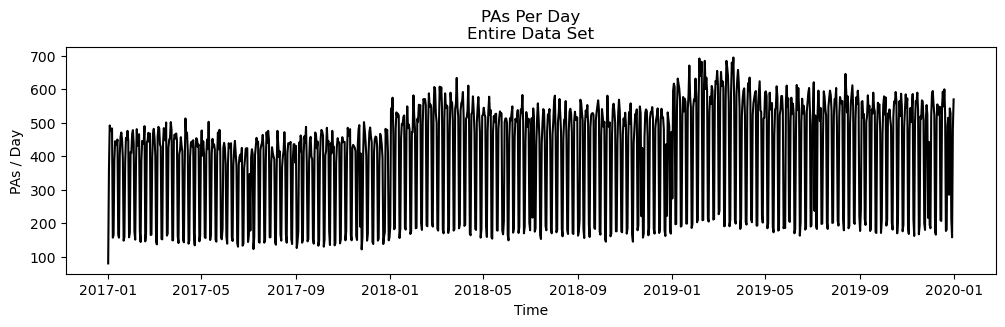

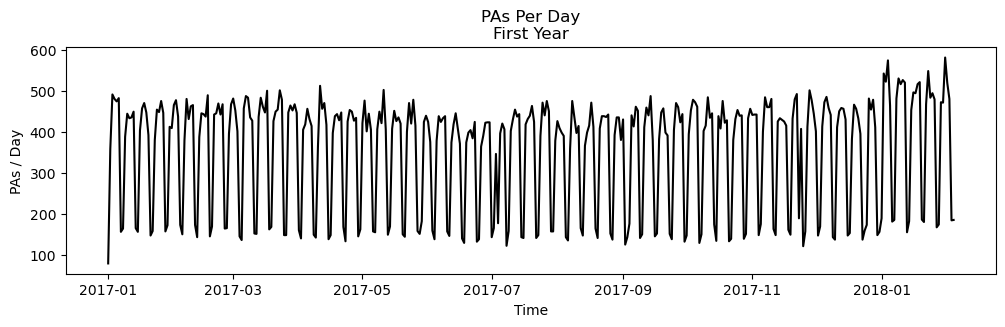

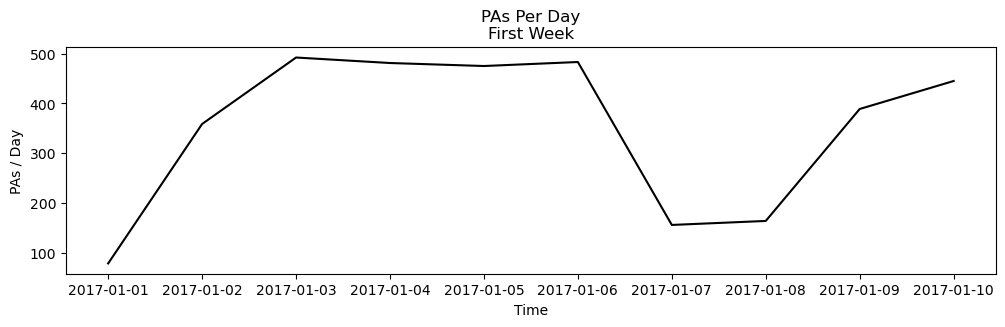

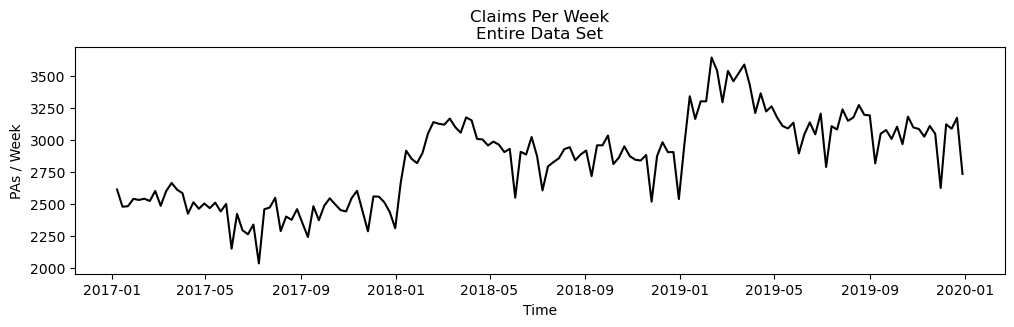

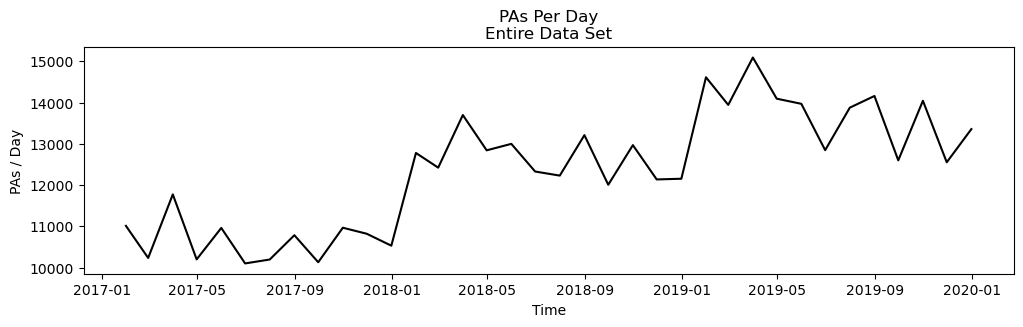

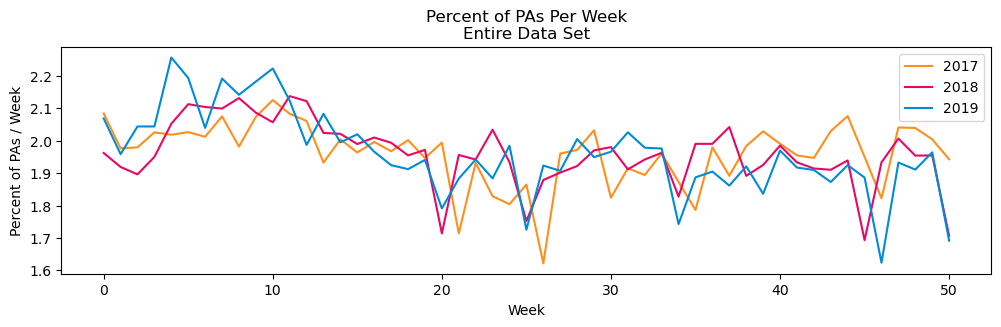

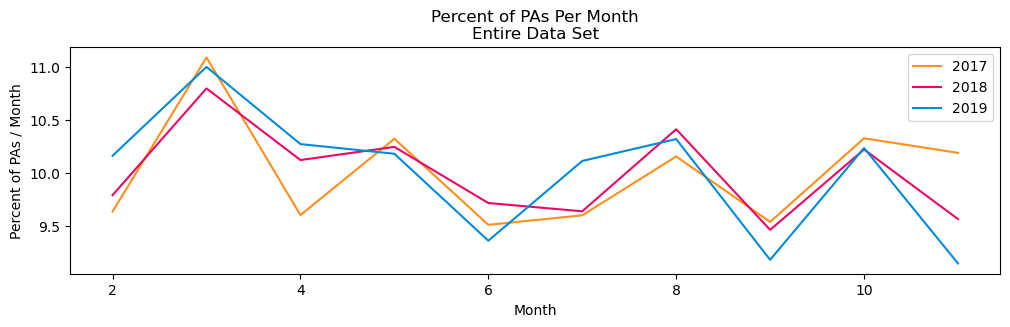

In [4]:
f, axes = plt.subplots(1, 1, figsize=(12, 3), dpi=100)
plt.title('PAs Per Day\nEntire Data Set')
plt.plot(merged.groupby('date_val')['pa_approved'].count(), 'k')
plt.ylabel('PAs / Day')
plt.xlabel('Time')
plt.show()

f, axes = plt.subplots(1, 1, figsize=(12, 3), dpi=100)
plt.title('PAs Per Day\nFirst Year')
plt.plot(merged.groupby('date_val')['pa_approved'].count().iloc[:400], 'k')
plt.ylabel('PAs / Day')
plt.xlabel('Time')
plt.show()

f, axes = plt.subplots(1, 1, figsize=(12, 3), dpi=100)
plt.title('PAs Per Day\nFirst Week')
plt.plot(merged.groupby('date_val')['pa_approved'].count().iloc[:10], 'k')
plt.ylabel('PAs / Day')
plt.xlabel('Time')
plt.show()

f, axes = plt.subplots(1, 1, figsize=(12, 3), dpi=100)
plt.title('Claims Per Week\nEntire Data Set')
# need to truncate the first and last bins because the weeks are incomplete
plt.plot(merged.groupby('date_val').count().groupby(pd.Grouper(freq='W'))['pa_approved'].sum()[1:-1], 'k')
plt.ylabel('PAs / Week')
plt.xlabel('Time')
plt.show()

f, axes = plt.subplots(1, 1, figsize=(12, 3), dpi=100)
plt.title('PAs Per Day\nEntire Data Set')
plt.plot(merged.groupby('date_val').count().groupby(pd.Grouper(freq='M'))['pa_approved'].sum(), 'k')
plt.ylabel('PAs / Day')
plt.xlabel('Time')
plt.show()

f, axes = plt.subplots(1, 1, figsize=(12, 3), dpi=100)
for year, view in merged.groupby('calendar_year'):
    # need to truncate the first and last bins because the weeks can be incomplete
    view = view.groupby('date_val').count().groupby(pd.Grouper(freq='W'))['pa_approved'].sum()[1:-1]
    view = view / view.sum() * 100

    plt.title('Percent of PAs Per Week\nEntire Data Set')
    plt.plot(view.values, label=year, color=YEAR_COLORS[year])
    plt.ylabel('Percent of PAs / Week')
    plt.xlabel('Week')
plt.legend()
plt.show()
    
f, axes = plt.subplots(1, 1, figsize=(12, 3), dpi=100)
for year, view in merged.groupby('calendar_year'):
    view = view.groupby('date_val').count().groupby(pd.Grouper(freq='M'))['pa_approved'].sum()[1:-1]
    view = view / view.sum() * 100

    plt.title('Percent of PAs Per Month\nEntire Data Set')
    plt.plot(np.array(view.index.month).astype(int), view.values, label=year, color=YEAR_COLORS[year])
    plt.ylabel('Percent of PAs / Month')
    plt.xlabel('Month')
plt.legend()
plt.show()

# Prior Authorization Approval Rate
## How does PA approval rate change with time for each payer/drug combination?
- Aggregation by week and month is required to obtain smooth rates due to the small number of PAs each day.
- No trends in PA authorization rate.

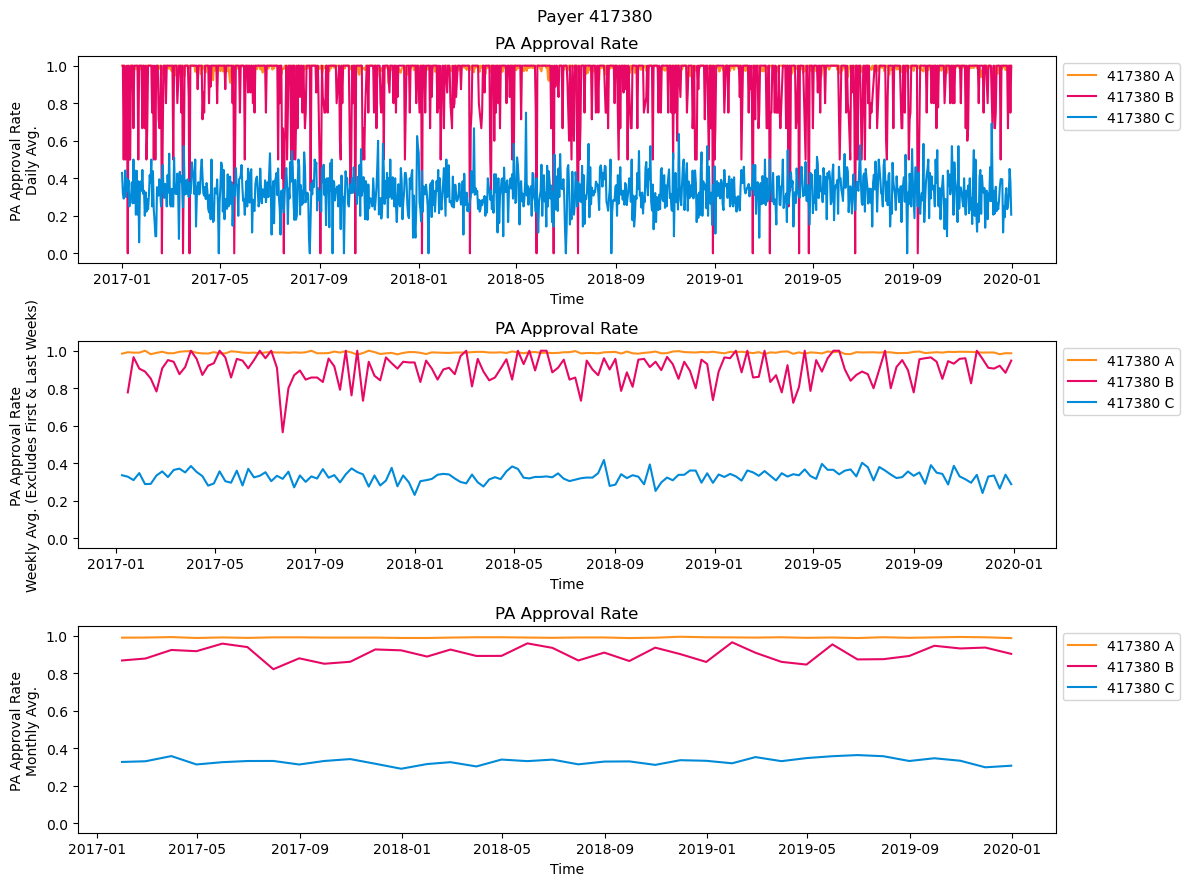

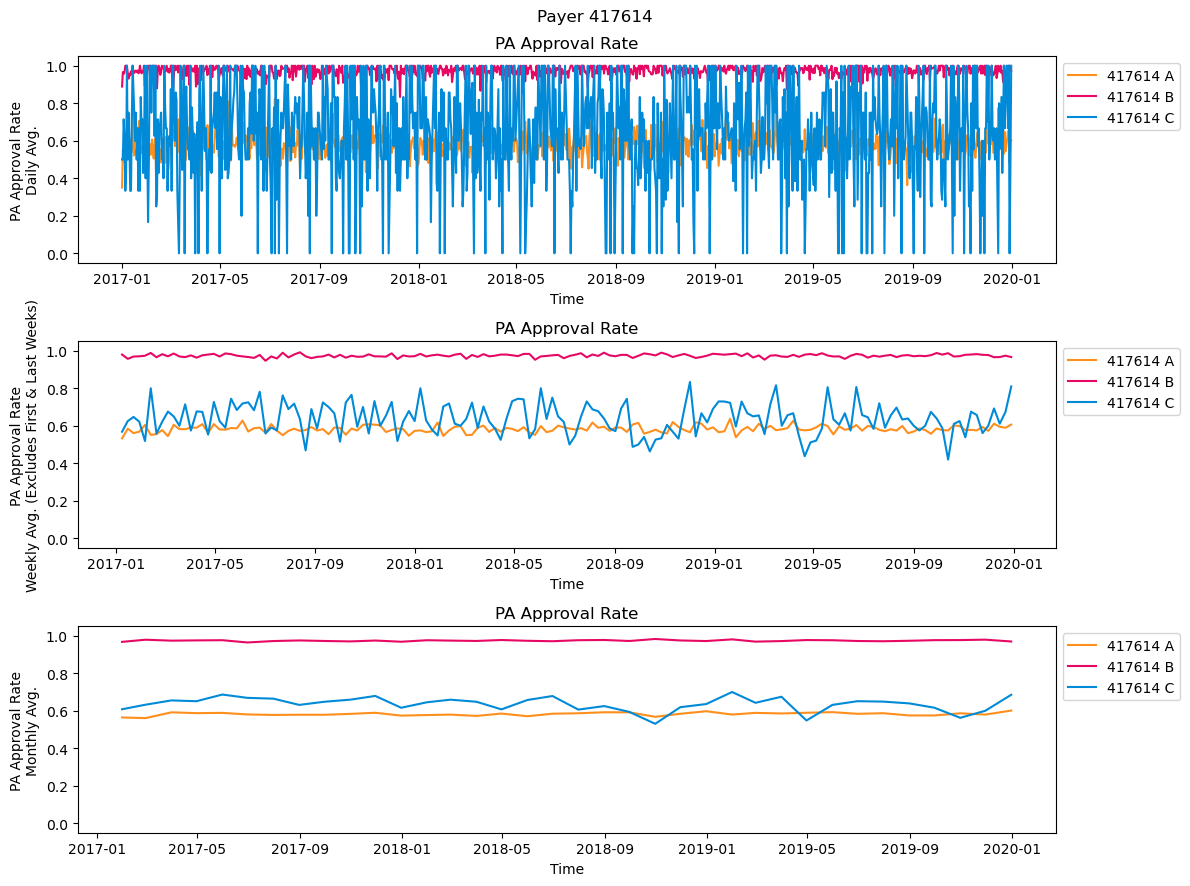

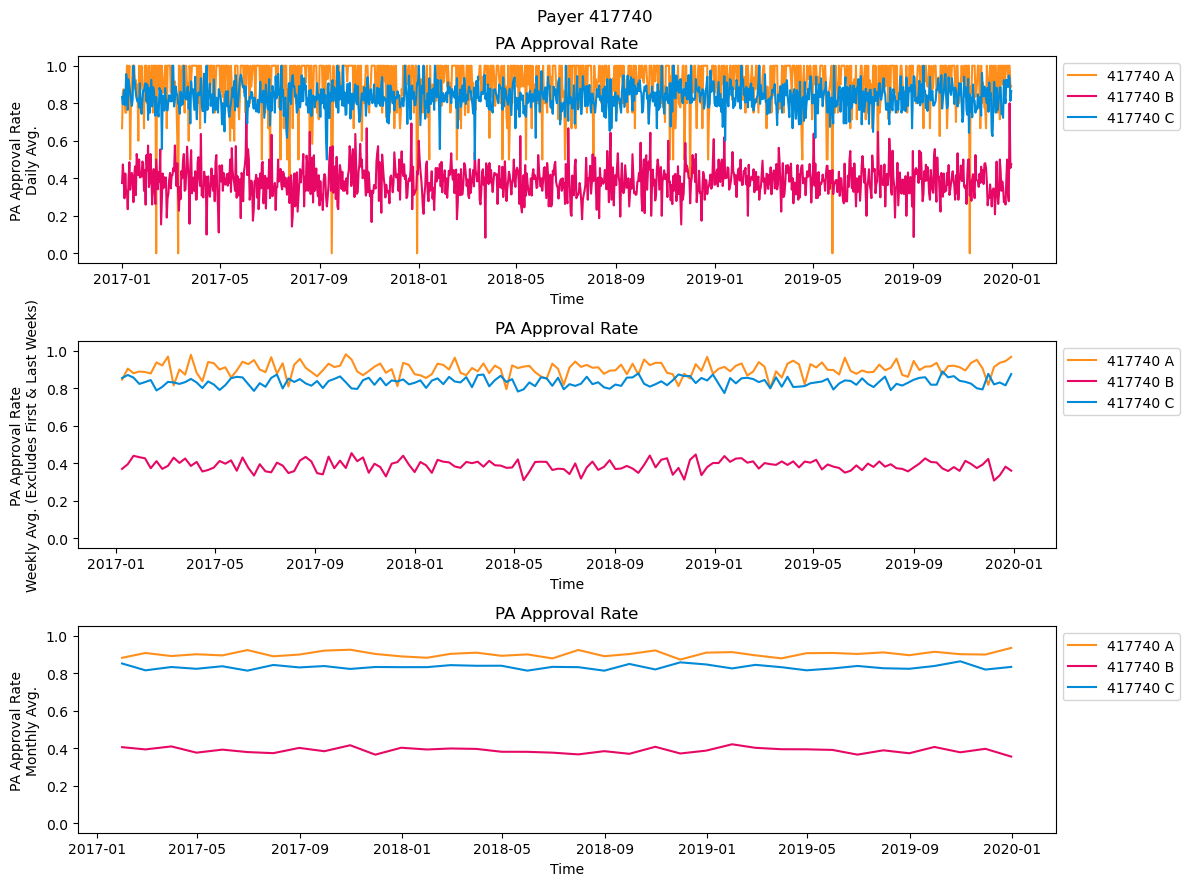

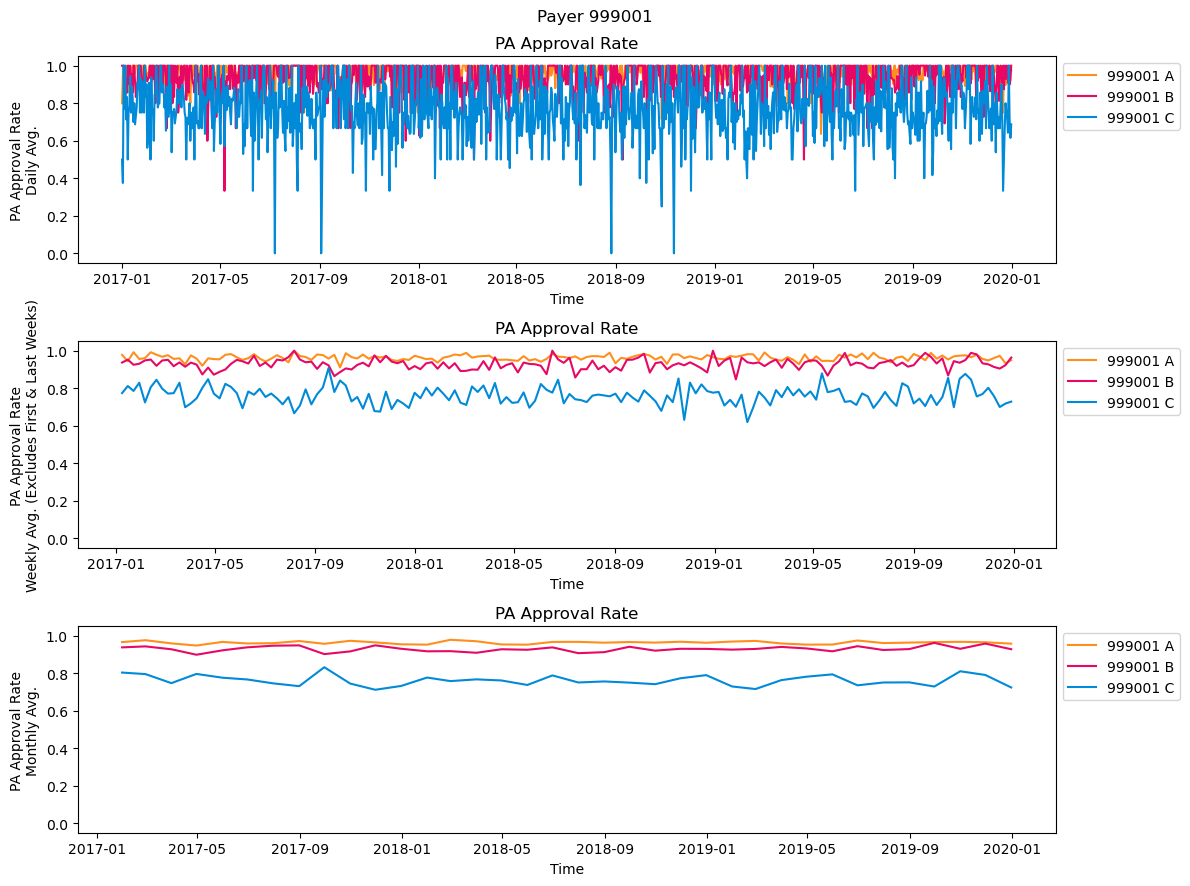

In [5]:
# sort the payer labels so that the legends appear in sorted order
for payer in sorted(merged['bin'].unique()):
    f, axes = plt.subplots(3, 1, figsize=(12, 9), dpi=100)
    f.suptitle(f'Payer {payer}')
    for drug in merged['drug'].unique():
        segment = merged.loc[(merged['bin'] == payer) & (merged['drug'] == drug)]

        approved = segment.groupby('date_val')['pa_approved'].sum()
        total = segment.groupby('date_val')['pa_approved'].count()

        axes[0].set_title('PA Approval Rate')
        axes[0].plot(approved / total, label=str(payer) + ' ' + drug, color=DRUG_COLORS[drug])
        axes[0].set_ylabel('PA Approval Rate\nDaily Avg.')
        axes[0].set_xlabel('Time')

        approved = segment.groupby('date_val').sum().groupby(pd.Grouper(freq='W'))['pa_approved'].sum()[1:-1]
        total = segment.groupby('date_val').count().groupby(pd.Grouper(freq='W'))['pa_approved'].sum()[1:-1]

        axes[1].set_title('PA Approval Rate')
        axes[1].plot(approved / total, label=str(payer) + ' ' + drug, color=DRUG_COLORS[drug])
        axes[1].set_ylabel('PA Approval Rate\nWeekly Avg. (Excludes First & Last Weeks)')
        axes[1].set_xlabel('Time')
        
        approved = segment.groupby('date_val').sum().groupby(pd.Grouper(freq='M'))['pa_approved'].sum()
        total = segment.groupby('date_val').count().groupby(pd.Grouper(freq='M'))['pa_approved'].sum()

        axes[2].set_title('PA Approval Rate')
        axes[2].plot(approved / total, label=str(payer) + ' ' + drug, color=DRUG_COLORS[drug])
        axes[2].set_ylabel('PA Approval Rate\nMonthly Avg.')
        axes[2].set_xlabel('Time')

    for ax in axes:
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        ax.set_ylim(-0.05, 1.05)
    plt.tight_layout()
    plt.show()